### Description

This notebook aims to apply the quantile neural network to predict mean reflectivity rada data. The data are avaiable in [https://www.arm.gov/research/campaigns/amf2014goamazon](https://www.arm.gov/research/campaigns/amf2014goamazon). 

> **Tip**:
>The data can be easily downloaded using the module [goamazondownloader](https://github.com/AdrianoPereira/goamazondownloader)

### Import libraries

Importing modules e libraries to read of data, preprocessing, visualization and neural network models.

In [279]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typhon.retrieval.qrnn import QRNN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

### Load data

The data are matrices (241x241) representing the radar's reflectivity echoes. Each attribute ($x_i$) will be the accumulated reflectivity at times t, t-1, ..., t-4 and output the reflectivity accumulated at time t + 1.

In [280]:
paths = list()
for root, dirs, files in os.walk('../data/matrizes'):
    for file in files:
        paths.append(os.path.join(root, file))
paths = np.asarray(sorted(paths))

X, Y = list(), list()
size_input = 5 
for i in range(size_input, paths.size):
#     print(np.arange(i-size_input, i), i)
    X.append(list())
    for j in range(i-size_input, i):
        mat = np.load(paths[j])
        X[i-size_input].append(mat)
    mat = np.load(paths[i])
    Y.append(mat)
X = np.asarray(X)
Y = np.asarray(Y)

### Preprocessing data

Filtering the input data so that it has only complete time series and normalize data.

In [281]:
X_data = list() 
Y_data = list()

for i, xval in enumerate(X):
    aux = list()
    for frame in xval:
        temp = np.nansum(frame)
        if temp < 1:
            break
        aux.append(temp)
    temp = np.nansum(Y[i])
    if len(aux) == size_input and temp > 0:
        X_data.append(aux)
        Y_data.append(temp)
        
X_data = np.asarray(X_data)
Y_data = np.expand_dims(np.asarray(Y_data), 1)

norm = MinMaxScaler(feature_range=(0, 1))
X_data = norm.fit_transform(X_data)
Y_data = norm.fit_transform(Y_data)

### Split test and train data

Splitting data into training (85%) and testing set (15%).

In [282]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=.15)

print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)

print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (320, 5)
y_train:  (320, 1)
X_test:  (57, 5)
y_test:  (57, 1)


### Build model

Building quantile neural network model with the 10th, 5th and 90th quantiles. Internally, the QRNN uses a feed-forward neural network that is trained to minimize the quantile loss function [(TAYLOR, 2000)](#).

$$
L_\tau(y_\tau, y_{true}) =
            \begin{cases} (1 - \tau)|y_\tau - y_{true}| & \text{ if } y_\tau < y_\text{true} \\
            \tau |y_\tau - y_\text{true}| & \text{ otherwise, }\end{cases}
$$

Where $y_\text{true}$ is the expected value of the retrieval quantity
and and $y_\tau$ is the predicted quantile. The neural network
has one output neuron for each quantile to estimate.


In [283]:
input_dim = X_train.shape[1]
quantiles = [0.1, 0.5, 0.9]

model = QRNN(input_dim=input_dim, quantiles=quantiles)

### Training model

Training model with batch size equals to 16 and using Learning Rate decay as callback. The LRDecay class implements the Keras callback interface and reduces the learning rate according to validation loss reduction.

In [293]:
batch_size = 16

history = model.fit(x_train=X_train, y_train=y_train, x_val=X_test, y_val=y_test,
          epochs=100, batch_size=16, verbose=True)

Epoch 1/200
20/20 [==============================] - 0s 23ms/step - loss: 0.0261 - val_loss: 0.0342
Epoch 2/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0259 - val_loss: 0.0302
Epoch 3/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0265 - val_loss: 0.0285
Epoch 4/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0292
Epoch 5/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0259 - val_loss: 0.0302
Epoch 6/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0256 - val_loss: 0.0308
Epoch 7/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0255 - val_loss: 0.0320
Epoch 8/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0251 - val_loss: 0.0316
Epoch 9/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0257 - val_loss: 0.0324
Epoch 10/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0256 - val_loss: 0.0305
Epoch 11

20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 84/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0231 - val_loss: 0.0287
Epoch 85/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 86/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 87/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 88/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0286
Epoch 89/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 90/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 91/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 92/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 93/200


20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 165/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 166/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 167/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 168/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 169/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 170/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 171/200
20/20 [==============================] - 0s 2ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 172/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0287
Epoch 173/200
20/20 [==============================] - 0s 1ms/step - loss: 0.0230 - val_loss: 0.0287
Epoc

### Evaluate model

The model can be evaluated through posterior probability density function. The boxes plots in the cell below are the posterior PDF prediction and markers `x` are true value. 

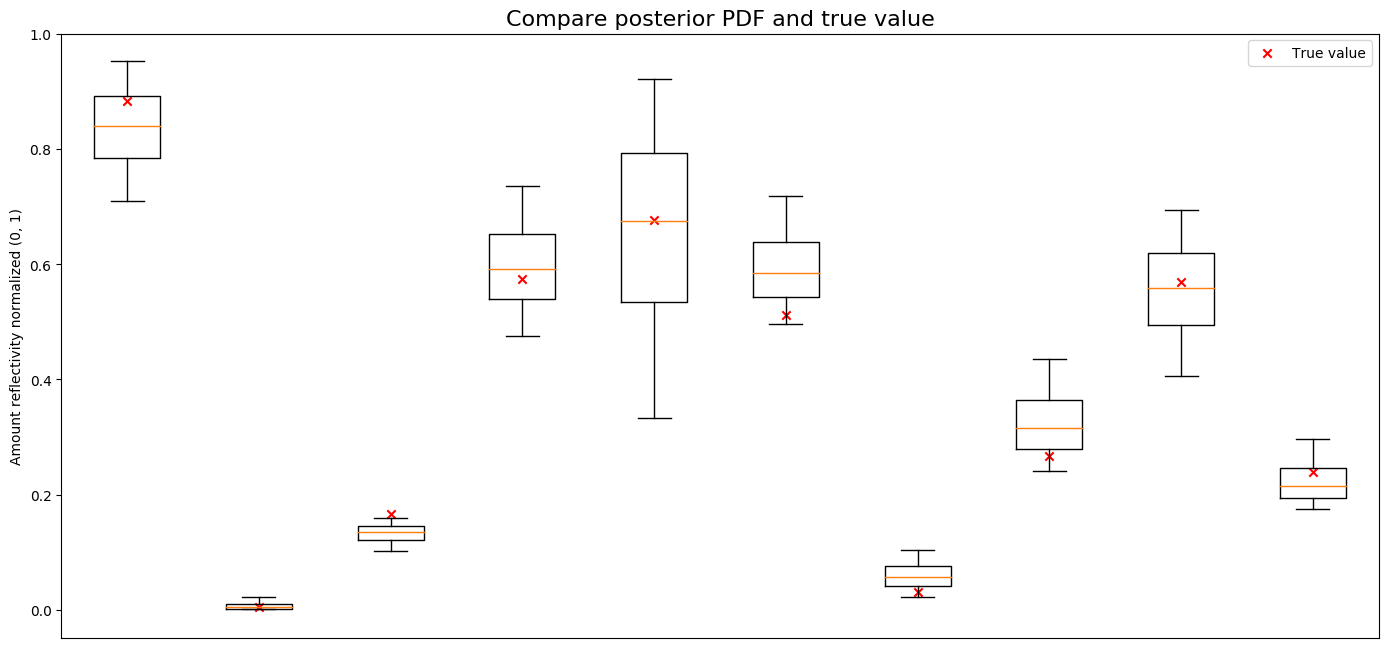

In [324]:
size_sample = 10
samples = X_test[:size_sample]

boxes = list()
for row in samples:
    x, y = model.pdf(row)
    boxes.append(x)
    
fig, ax = plt.subplots(figsize=(17, 8), dpi=100)

ax.set_title('Compare posterior PDF and true value', fontdict=dict(fontsize=16))
_ = ax.boxplot(boxes)
ax.scatter(np.arange(size_sample)+1, y_test[:size_sample, 0], marker='x', color='r', label='True value')
ax.set_xticks([])
ax.set_ylabel('Amount reflectivity normalized (0, 1)')
ax.legend()


Correlation between true value and predicted value by quantil

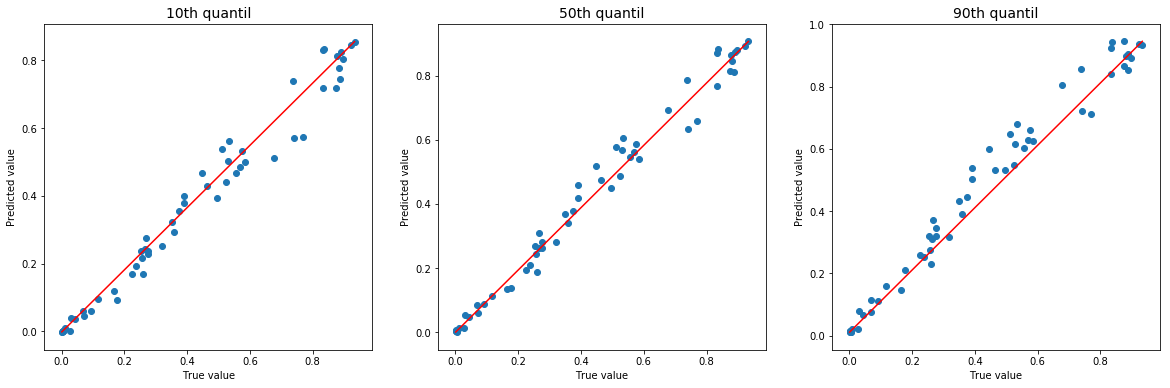

In [347]:
y_pred = model.predict(X_test)

fig, ax = plt.subplots(1, len(quantiles), figsize=(20, 6.))

for i, quantil in enumerate(quantiles):
    true, pred = y_test[:, 0], y_pred[:, i]
    ax[i].set_title('%dth quantil'%(quantil*100), fontdict=dict(fontsize=14))
    ax[i].scatter(true, pred)
    ax[i].plot([true.min(), true.max()], [pred.min(), pred.max()], color='r')
    ax[i].set_xlabel('True value')
    ax[i].set_ylabel('Predicted value')

### References

- Taylor, J.W., 2000. **A quantile regression neural network approach to estimating the conditional density of multiperiod returns**. *Journal of Forecasting* 19 (4), 299–311.


- Cannon A. J. 2011. **Quantile regression neural networks: Implementation in R and application to precipitation downscaling**. *Computers & Geosciences*. 37 (9), 1277–1284.


- Lemke, O., Kluft, L., Mrziglod, J., Pfreundschuh, S., Holl, G., Larsson,R., Yamada, T., Mieslinger, T., and Doerr, J. (2020).  **atmtools/typhon: Typhon release0.8.0**. Avaiable in: [https://github.com/atmtools/typhon/tree/v0.8.0](https://github.com/atmtools/typhon/tree/v0.8.0). Accessed 13 July 2020.